In [1]:
import sys
sys.path.insert(0, '../')
from lib import *
import lib.matplotlib_style #Some nice defaults for matplotlib


%matplotlib inline


DEBUG = True;
DEBUG = False;

Chan_dic={}
Chan_dic[0]=0
Chan_dic[1]=1
Chan_dic[3]=2
Chan_dic[4]=3
Chan_dic[5]=4


## Functions

In [2]:
#functions:
def gauss(x,a,x0,sigma):
    return a*np.exp(-0.5*np.power((x-x0)/sigma,2))

def gaussian_train(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        height = params[i]
        center = params[i+1]
        width  = params[i+2]
        y      +=  gauss(x, height, center, width)
    return y

def fit_gaussians(x, y, *p0):
    assert x.shape == y.shape, "Input arrays must have the same shape."
    # try:
    popt, pcov = curve_fit(gaussian_train, x,y, p0=p0[0])
    fit_y=gaussian_train(x,*popt)
    chi_squared = np.sum((y[abs(fit_y)>0.1] - fit_y[abs(fit_y)>0.1]) ** 2 / fit_y[abs(fit_y)>0.1]) / (y.size - len(popt))
    # plt.figure(dpi=200, figsize=(6, 3))
    # fig = plt.axes()
    # plt.plot(x, y, 'b-', label='data')
    # plt.plot(x, fit_y, 'r-', label='fit',linewidth=1)
    # plt.grid()
    return popt,fit_y, chi_squared
    # except:
    #     print("Fit failed.")



##Binomial+Poisson distribution

from math import factorial as fact
import numpy as np
from scipy.stats import poisson
def B(i,k):
    #factorial factor of F
    if (i==0) & (k==0):return 1;
    if (i==0) & (k>0): return 0;
    else:
        return (fact(k-1) * fact(k)
                /(fact(i-1)*fact(i)*fact(k-i) )
               )

def F(K,p,L):
    ## computes prob of the kth point in a convoluted poisson+binomial distribution, 
    # L is the mean value of the poisson, p is the binomial coef, i.e. the crosstalk we want to compute
    

    aux_sum=0
    if DEBUG: print(K)
    for i in range(K+1):
        aux_sum+=B(i,K)*((L *(1 - p))**i)  *  (p**(K - i)) 

    return np.exp(-L)*aux_sum/fact(K);

def PoissonPlusBinomial(x,p,L):
    N=len(x)
    aux=np.zeros(shape=N)
    for i in range(N):
        if DEBUG: print(x,i,x[i])
        aux[i]= F(int(x[i]),p,L);
    
    return aux/sum(aux);


# Gabriel method (Poisson+Binomial distribution)

-------OV:   7-------
Initial vars: 0.4387517192477669 	 2.3669578825336344


/usr/local/lib64/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning:

Covariance of the parameters could not be estimated



Fitted vars:  [-0.31935066  0.52262345]
Rel Error:  [-90.30414314  54.92754292]
-------OV:   9-------
Initial vars: 0.11167270915654748 	 2.1260293978797904
Fitted vars:  [0.14309684 2.1947816 ]
Rel Error:  [9.62501057 1.14209568]
-------OV:   12-------
Initial vars: 0.16860185219197543 	 2.2081630406600277
Fitted vars:  [0.25661651 2.33601577]
Rel Error:  [15.36867892  2.84582507]


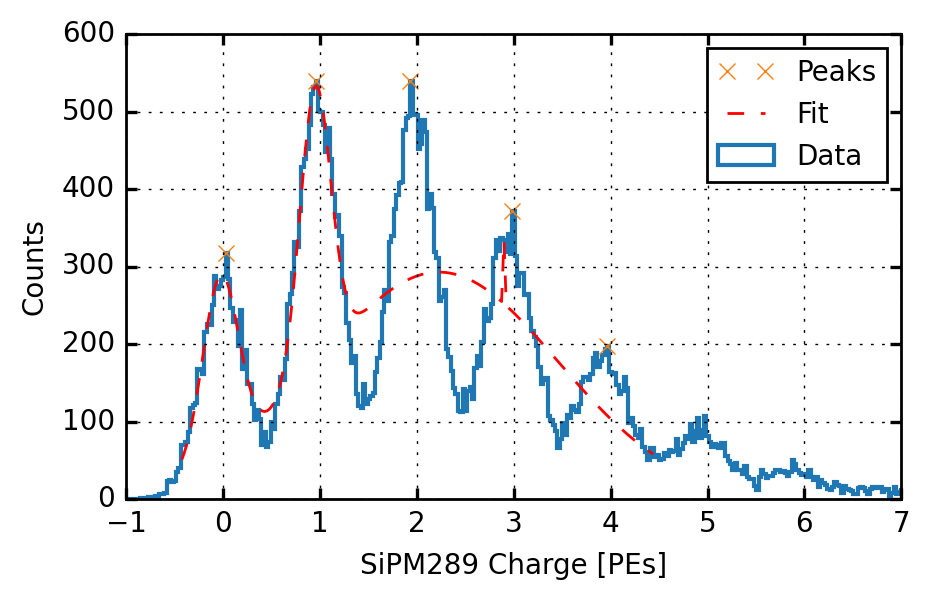

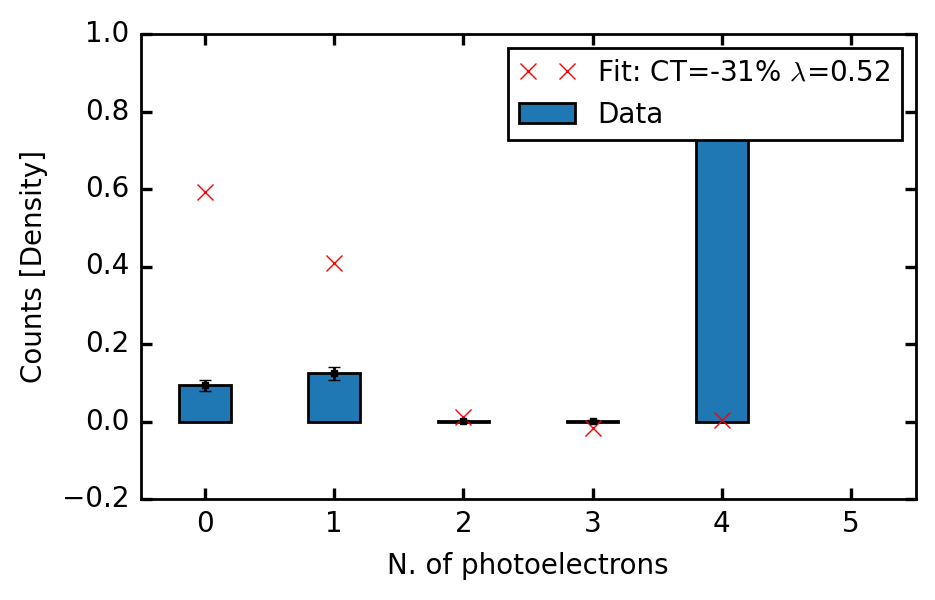

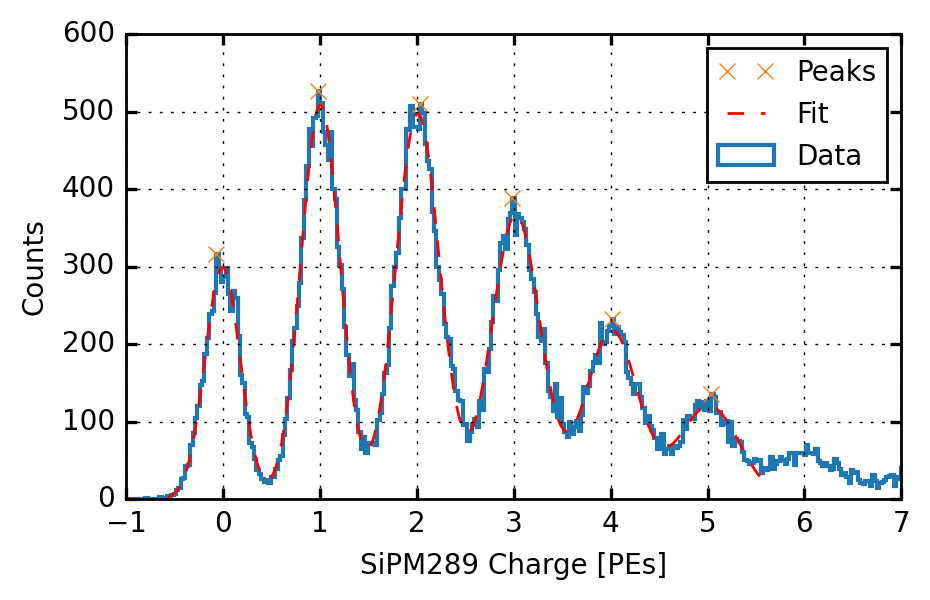

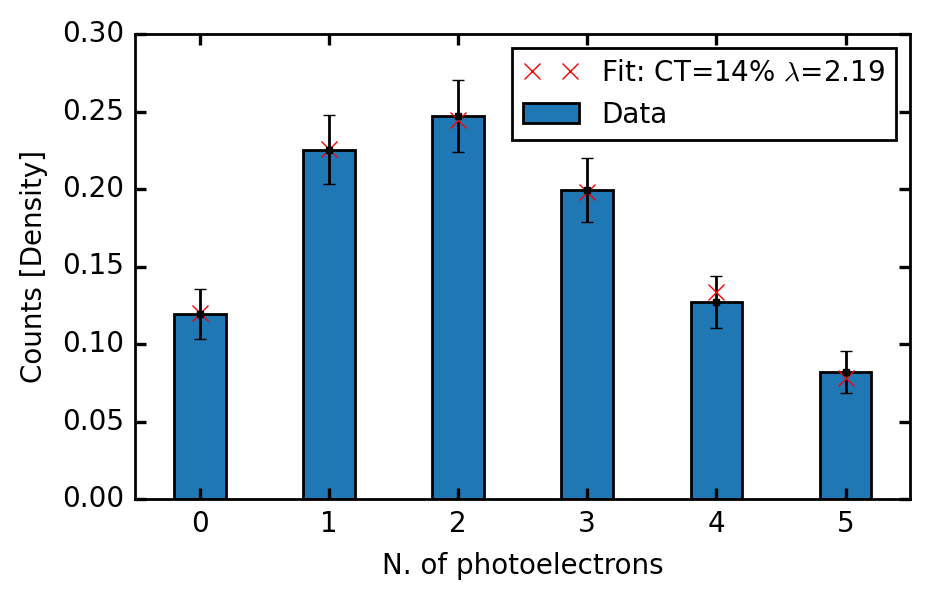

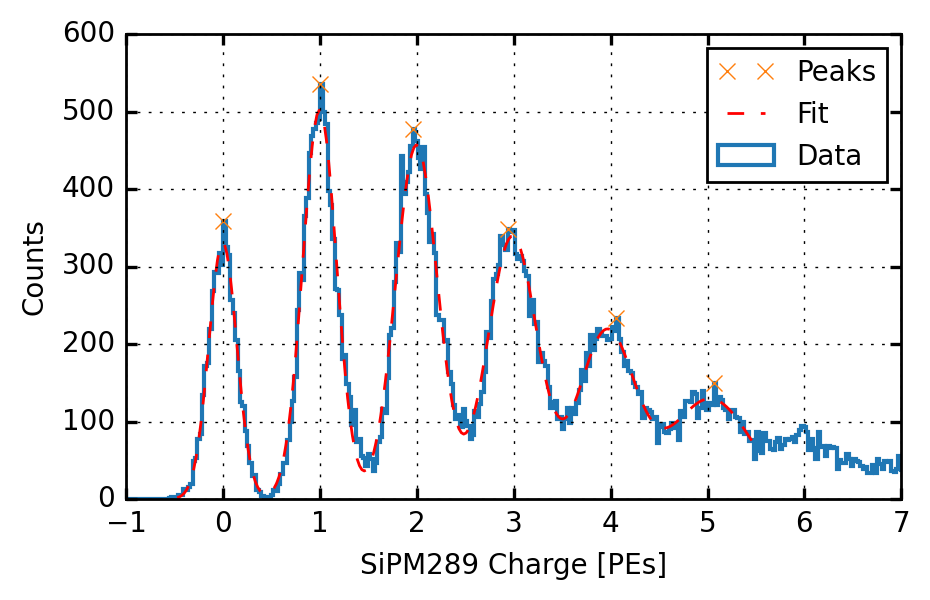

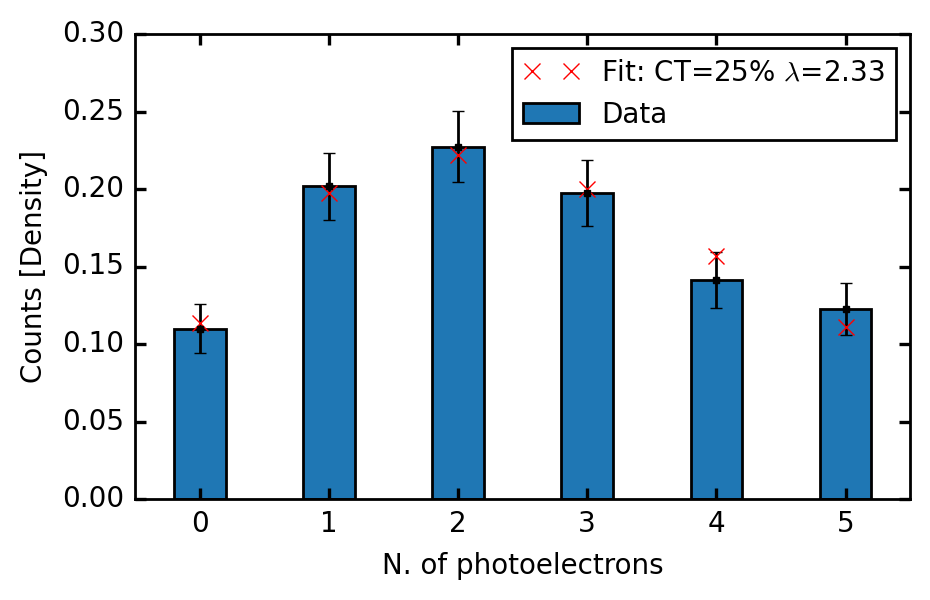

In [47]:
compress=False
file_CT=[];

# WEEK="APSAIA_VUV_2";OV=2.5
# WEEK="APSAIA_VIS";OV=2.5
# WEEK="APSAIA_VUV";#OV=3
# for OV in [2,2.5,3]:




# WEEK="DAPHNE_VIS";
WEEK="DAPHNE_VUV";
for OV in [7,9,12]:




    path="/scr/neutrinos/rodrigoa/"+WEEK+"/joython/"
    Runs=open_runs_table("../macros/"+WEEK+".xlsx")

    Calib_run=Runs[(Runs["Type"]=="Calibration") & ( Runs["OverVoltageXA"]==OV)].iloc[2]
    print("-------OV:   "+str(OV)+"-------")
    run=Calib_run["Run"]


    for ch in [0]:
        if Calib_run["ChannelName"][Chan_dic[ch]].__contains__("SiPM"): OV=Calib_run["OverVoltageSiPMs"]
        else:OV=Calib_run["OverVoltageXA"]

        ADCsxticks2PE=GetGains(WEEK,Chan_dic[ch],OV)
        run_path=path+"run"+str(run).zfill(2)+"/";
        Charge_vars   = open_ch_var(run_path ,"Charge_vars"   ,ch,compressed=compress)
        Peak_vars     = open_ch_var(run_path  ,"Peak_vars"   ,ch,compressed=compress)
        Pedestal_vars = open_ch_var(run_path  ,"Pedestal_vars_SW"   ,ch,compressed=compress)

        #plot charge distribution from raw calibration data
        for charge in ["ChargeRangeAverageWvf"]:

            # plt.semilogy()
            Bins=450
            r=[-1,10]
           
           
           

            #get counts
            counts,bins= np.histogram(Charge_vars[charge]*ADCsxticks2PE,Bins,r);
            
            #find peaks
            peaks=find_peaks(counts,height=120,width=4,distance=int(Bins/((r[1]-r[0])*1.2))  )
            
            

            #right limit:(supossing same space between peaks, prevents adding more gaussians that the ones considered to be fitted)
            r_lim=peaks[0][-1]+ int (((peaks[0][-1]-peaks[0][-2]))/2)
            
            l_lim=peaks[0][0]- int (((peaks[0][1]-peaks[0][0]))/2)
            
            params=np.zeros(len(peaks[0])*3)
            params[0::3]=peaks[1]["peak_heights"]
            params[1::3]=bins[peaks[0]]
            params[2::3]=0.5
            
            vars,fit_y,qs=fit_gaussians(bins[:-1][l_lim:r_lim],counts[l_lim:r_lim],params)
            

            # 1st Plot: gaussian fits
            plt.figure(dpi=200,figsize=(5,3))
            plt.hist(Charge_vars[charge]*ADCsxticks2PE,bins=Bins,range=r,histtype="step",label="Data",linewidth=1.5)
            plt.xlim([-1,7]) 
            plt.plot(bins[peaks[0]],peaks[1]["peak_heights"],"x",label="Peaks")
            plt.plot(bins[:-1][l_lim:r_lim] +(bins[1]-bins[0])/2  ,fit_y,'--',color="red",label="Fit")        
            plt.legend(fontsize=10)
            plt.xlabel(Calib_run["ChannelName"][Chan_dic[ch]] +" Charge [PEs]")
            plt.ylabel("Counts")
            plt.grid()
            
            #Compute Gaussian areas
            Amp=vars[0::3]
            sigma=np.abs(vars[2::3])
            
            #prob is proportional to A*sigma (sqrt(2pi))
            PNs=Amp*sigma/sum(Amp*sigma)
            
            #assuming error propt to sqrt(N)
            PNs_err=(Amp*sigma)**0.5/sum(Amp*sigma)
            
            if DEBUG:
                print(Amp)
                print(sigma)
                print(PNs)
                print(PNs_err)

            
            P0=PNs[0]
            P1=PNs[1]
            l=-np.log(P0)
            p=1-P1/(l*P0)
            print("Initial vars:",p,"\t",l)
                



            # 2nd plot, Vinogradov fit
            fig, ax = plt.subplots(1,dpi=200,figsize=(5,3))

            plt.xlim([-.5,5.5]) 
            # Get the peaks that were fitted
            a=np.arange(Bins)*(r[1]-r[0])/Bins
            b=a[peaks[0]]-1
            
            xdata=b.round().astype(int).tolist()
            if DEBUG: print(b,xdata)


            plt.errorbar(x=xdata,y=PNs,yerr=PNs_err, color="k",linestyle="none",marker="s",markersize=2,capsize=2,)
            plt.bar(np.array(xdata),PNs,label="Data",width=0.4)

            p0=[p,l]
            popt, pcov = curve_fit(PoissonPlusBinomial, xdata,PNs,sigma=PNs_err, p0=p0)

            plt.plot(xdata, PoissonPlusBinomial(xdata, *popt), 'x',label="Fit: CT=" +str(int(popt[0]*100)) +"% $\lambda$="+str(int(popt[1]*100)/100),color="red")

            plt.ylabel("Counts [Density]")
            plt.xlabel("N. of photoelectrons")
            plt.legend(fontsize=10)
            # Display also the ideal poisson dist
            # ideal=poisson.pmf(xdata, mu=popt[1])
            # plt.bar(np.array(xdata)+.3,ideal,width=.3)

            print("Fitted vars: ",popt)
            perr = np.sqrt(np.diag(pcov))
            print("Rel Error: ", perr/popt*100)
            
            #save values to file

            file_CT.append([OV,popt[0],perr[0]])
    
arr = np.asarray(file_CT)
np.savetxt('CT_'+WEEK+"_CH_"+Calib_run["ChannelName"][Chan_dic[ch]]+ '_.csv',arr, delimiter=",")    

## Demostration plot: poisson vs poisson+binomial

Text(0.5, 0, '#Photo-Electrons [N]')

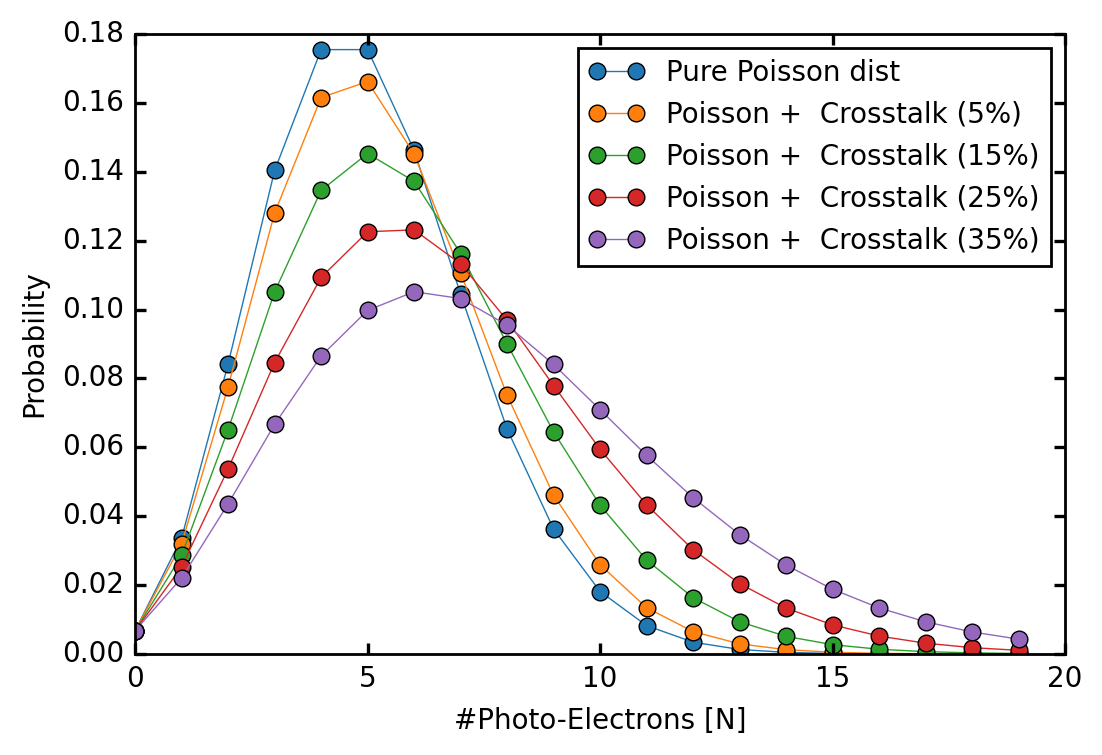

In [21]:

L=5

x=poisson.pmf(range(20), mu=L)


plt.figure(dpi=200)
plt.plot(x,'o-',label="Pure Poisson dist",linewidth=0.5)


for ct in np.arange(0.05,.4,0.1):
    # x=[F(i,ct,L) for i in range(20)]
    x=PoissonPlusBinomial(range(20) ,ct , L)
    
    plt.plot(x,'o-',label="Poisson +  Crosstalk ("+str(int(ct*100))+"%)",linewidth=0.5 )

plt.legend(fontsize=10)
plt.ylabel("Probability")
plt.xlabel("#Photo-Electrons [N]")

